In [1]:
# Cirunay, Manejo - Lab03 Blended Images
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to apply Gaussian blur
def apply_gaussian(image, levels, sigma):
    gaussian = []
    for i in range(levels):

        # Kernel size
        kernel_size = ((3*sigma)//2)*2+1

        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
        gaussian.append(blurred_image)

        # Increase sigma for the next level
        sigma *= 2

    return gaussian

In [3]:
def laplacian_effect(img, levels, sigma):
    laplacian = []

    # Apply Gaussian blur and create the Gaussian pyramid
    gaussian = apply_gaussian(img, levels + 1, sigma)

    for i in range(levels):
        laplacian_image = cv2.subtract(gaussian[i], gaussian[i + 1])
        laplacian.append(laplacian_image)
        
    return laplacian

In [4]:
# Function to blend two images
def blend_images(img1, img2, mask, levels, sigma):

    # Apply gaussian and laplacian
    gaussian1 = apply_gaussian(img1, levels, sigma)
    gaussian2 = apply_gaussian(img2, levels, sigma)
    gaussianMask = apply_gaussian(mask, levels, sigma)

    laplacian1 = laplacian_effect(img1, levels, sigma)
    laplacian2 = laplacian_effect(img2, levels, sigma)

    # Construct laplacian stack
    laplacian_stack = []
    for i in range(levels):
        # Lr(i) = Gm(i) * La(i) + (1 - Gm(i)) * Lb(i)
        blended_laplacian = gaussianMask[i] * laplacian1[i] + (1 - gaussianMask[i]) * laplacian2[i]
        laplacian_stack.append(blended_laplacian)

    # calculate final gaussian
    final_gaussian = gaussianMask[-1] * gaussian1[-1] + (1 - gaussianMask[-1]) * gaussian2[-1]

    output_image = final_gaussian
    for i in range(levels):
        # Add the current Laplacian stack final output
        output_image = cv2.add(laplacian_stack[i], output_image)

    return output_image

In [5]:
# Load the images and mask in color
img1 = cv2.imread('images/1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/2.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('images/mask.jpg', cv2.IMREAD_GRAYSCALE)

img1 = img1 / 255.0
img2 = img2 / 255.0
mask = mask / 255.0

# Initialize parameters
levels = 5
sigma = 1

In [6]:
# Function to display the Gaussian stack
def display_gaussian_stack(img, levels, sigma):
    # Apply Gaussian blur and get the Gaussian stack
    gaussian_stack = apply_gaussian(img, levels, sigma)

    # Display the Gaussian stack
    plt.figure(figsize=(12, 6))
    for i in range(levels):
        plt.subplot(1, levels, i + 1)
        plt.imshow(gaussian_stack[i], cmap='gray')
        plt.title(f'Gaussian Level {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
# Function to display the Laplacian stack
def display_laplacian_stack(img, levels, sigma):
    # Get the Laplacian stack
    laplacian_stack = laplacian_effect(img, levels, sigma)

    # Display the Laplacian stack
    plt.figure(figsize=(12, 6))
    for i in range(levels):
        plt.subplot(1, levels, i + 1)
        plt.imshow(laplacian_stack[i], cmap='gray', clim=(0, 0.1))
        plt.title(f'Laplacian Level {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

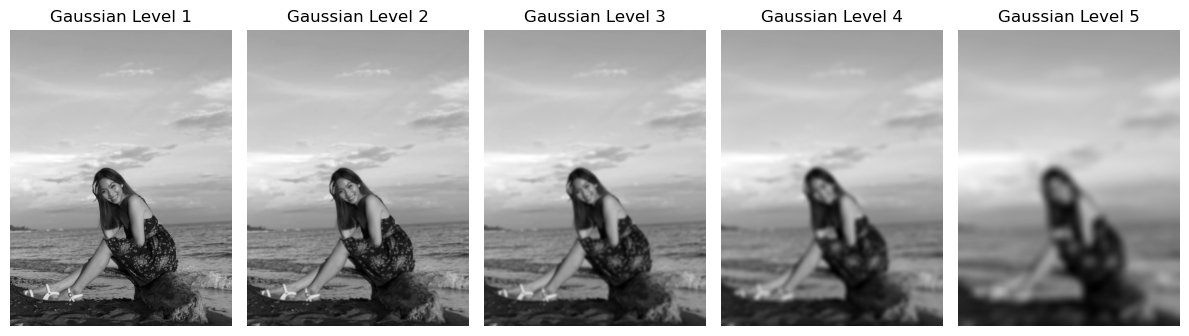

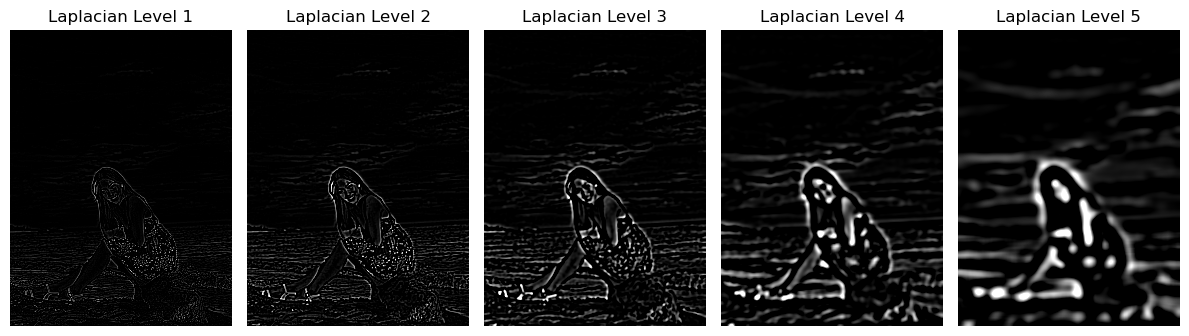

In [8]:
# Display Gaussian and laplacian stack for img2
display_gaussian_stack(img2, levels, sigma)
display_laplacian_stack(img2, levels, sigma)

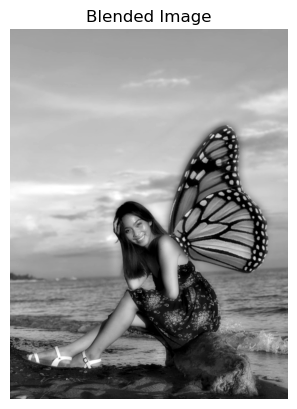

In [9]:
# Blend the images
blended_image = blend_images(img1, img2, mask, levels, sigma)
blended_image = np.clip(blended_image, 0, 1) 
blended_image = (blended_image * 255).astype(np.uint8)  

plt.imshow(blended_image, cmap='gray')
plt.title("Blended Image")
plt.axis("off")
plt.show()